# Dask - bringing scalability to Pandas

Dataset and rough guide from here: https://jcrist.github.io/dask-sklearn-part-3.html. We're going to grab a huge swath of flight history (from 1987-2008) and then try to do some EDA with over 120 million flights, on just one laptop.

**Note: Don't run this notebook! Certain cells will take nearly an hour to run. We're using this to show how cool Dask is, but it does have limitiation!**

[Jupyter extensions](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/) and particularly ExecuteTime should be installed in order to view the notebook.

In [1]:
from dask.distributed import Client, progress
client = Client(n_workers=4, threads_per_worker=2)
client

C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\distributed\dashboard\core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:56578 Dashboard: http://127.0.0.1:56581/status,Cluster Workers: 4 Cores: 8 Memory: 8.51 GB


In [ ]:
!conda install s3fs -c conda-forge

You may need to install s3fs in order for the following to work
```
conda install s3fs -c conda-forge
```

In [ ]:
import dask.dataframe as dd

# Subset of the columns to use
cols = ['Year', 'Month', 'DayOfWeek', 'DepDelay',
        'CRSDepTime', 'UniqueCarrier', 'Origin', 'Dest']

# Create the dataframe
df = dd.read_csv('s3://dask-data/airline-data/*.csv',
                 usecols=cols,
                 blocksize=int(128e6),
                 storage_options=dict(anon=True),
                 assume_missing=True)

Great, we've loaded our data. How many 128MB partitions are there?

In [ ]:
df.npartitions

So that's about 13GB of raw data, and I'm working on a machine with only 8GB of memory. Perfect. Let's do it.

In [ ]:
df.head()

In [ ]:
df['Year'].count().compute()

So all together, we have almost 123M rows worth of data. It took us over 40 minutes to calculate that though. This is why you often want to use Dask in-combination with Dask cluster computing. Right now, I'm basically just using my machine as a local, stand-alone cluster. So I'm not getting a huge benefit of parallelization. But, I am able to work on data that doesn't fit in RAM.

Let's do some analysis, however, I really only want to go through the data one time. So instead of doing it once for each type of analysis, I'm going to do three analyses at once.

In [ ]:
import dask
# Define some aggregations to plot
aggregations = (df.groupby('Year').DepDelay.mean(),
                df.groupby('Month').DepDelay.mean(),
                df.groupby('UniqueCarrier').DepDelay.mean().nlargest(15))

# Compute them all in a single pass over the data
(delayed_by_year,
delayed_by_month,
delayed_by_carrier) = dask.compute(*aggregations)

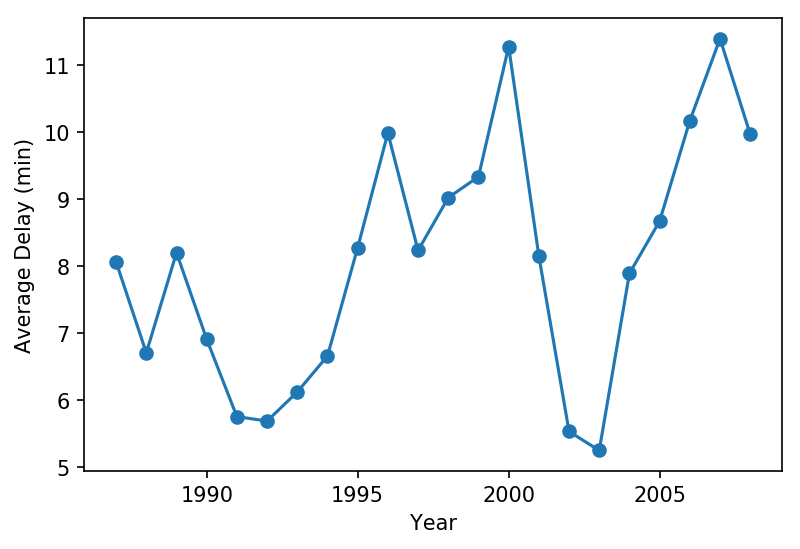

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(dpi=150)
plt.plot(delayed_by_year.index, delayed_by_year.values,'o-')
plt.xlabel("Year")
plt.ylabel("Average Delay (min)");

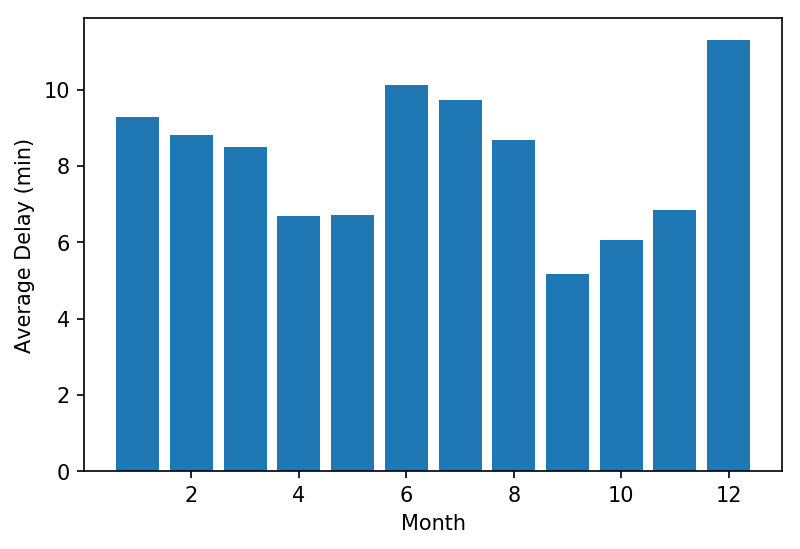

In [ ]:
plt.figure(dpi=150)
plt.bar(delayed_by_month.index, delayed_by_month.values)
plt.xlabel("Month")
plt.ylabel("Average Delay (min)");

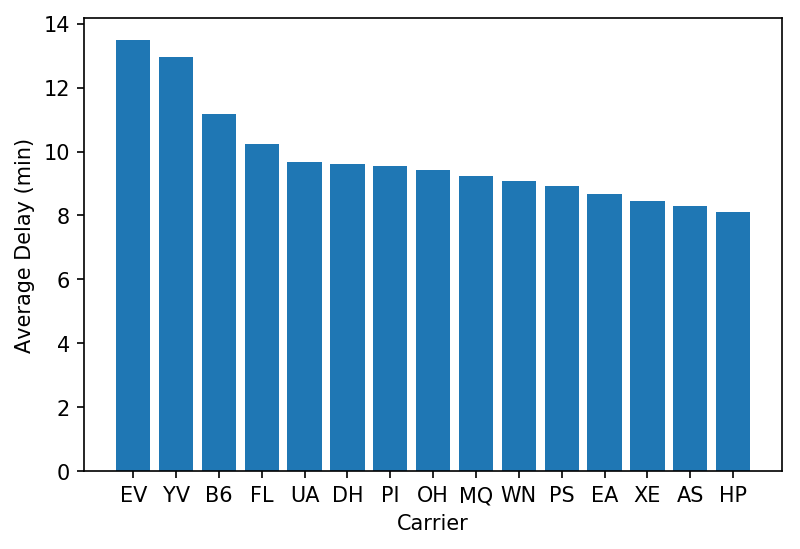

In [ ]:
plt.figure(dpi=150)
plt.bar(delayed_by_carrier.index, delayed_by_carrier.values)
plt.xlabel("Carrier")
plt.ylabel("Average Delay (min)");

So Dask is capable of working with data much larger than my machine's RAM. It's a bit slow if you don't properly setup the cluster computing side of things though. But, it's still a super powerful tool.